В данном проекте вам предстоит поработать с детекцией рака по cell-free RNA опухоли в крови по данным bulk-RNAseq. Исходные данные можно найти [здесь](https://drive.google.com/file/d/1gB2eHRyCHyGSSvtZq47ayoVA3GPDMNDX/view?usp=sharing).

* `Annotation_cell_lines.tsv.gz`: Аннотация раковых линий
* `Annotation_cells.tsv.gz`: Аннотация клеточных линий
* `Expression_cell_lines.tsv.gz`: Экспрессии раковых линий 
* `Expression_cells.tsv.gz`: Экспрессии клеточных линий
* `LUAD-expr.tsv`: bulk-RNAseq крови больного раком легкого
* `Normal-blood-expr.tsv`: bulk-RNAseq здоровой крови

Здесь мы также должны генерировать данные похожим образом, как в деконволюции, поэтому вам предлагается в начале заняться генерацией данных, а уже потом обучить модели.

Вам предлагаются данные экспрессий "чистых" клеток (линии). Bulk данные можно представить как линейная комбинация экспрессий "чистых" клеток. Например, 0.5 * B_cell + 0.5 * T_cell = Bulk_dataset. В таком случае мы можем взять "чистые" клетки в различных пропорциях и получить размеченные искусственные bulk-RNAseq данные. В отличие от деконволюции здесь мы хотим добавлять в смеси малые количества опухоли (1е-3 - 1е-1), создавая "больной" образец. Таким образом у нас получается бинарная классификаця: есть опухоль / нет.

Дальше можно обучить несколько моделей для предсказания наличия опухоли по данных bulk-RNAseq cfRNA крови.

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import randint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score


In [216]:
normal_blood_df = pd.read_csv ("Deconvolution\\Normal-blood-expr.txt", sep='\s+')
normal_blood_df.head(3)

(44792, 3)

In [19]:
normal_cell_genes = list(normal_blood_df.Gene)

In [20]:
normal_blood_df.Gene

0          5S_rRNA
1        5_8S_rRNA
2              7SK
3             A1BG
4         A1BG-AS1
           ...    
44787      snoZ278
44788       snoZ40
44789        snoZ6
44790     snosnR66
44791       uc_338
Name: Gene, Length: 44792, dtype: object

In [21]:
luad_df = pd.read_csv ("Deconvolution\\LUAD-expr.tsv", sep='\s+')
luad_df.head(3)

,Gene,VIC-020-CL,VIC-025-CL,VIC-026-CL,VIC-031-CL,VIC-033-CL,VIC-034-CL
0,A1BG,0.139650,0.000000,0.000000,0.000000,0.000000,0.000000
1,A1CF,0.050278,0.041802,0.010439,0.008841,0.006627,0.005353
2,A2M,166.111953,284.024569,77.175170,43.849792,19.417069,173.169681


In [240]:
# Преобразуем дата-сет с анализами от больных людей
bad_data = luad_df.set_index('Gene')
g_names = bad_data.index.values.tolist()
bad_data = bad_data.transpose()
target_1 = zeros = np.ones(6) 
bad_data.insert (loc= 0 , column='target', value=target_1)
bad_data.head(2)

Gene,target,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
VIC-020-CL,1.0,0.13965,0.050278,166.111953,0.220864,0.153432,6.714810,0.081386,11.871257,8.696697,...,13.169343,4.323443,12.412860,18.033103,0.665761,6.845210,105.675717,19.454571,18.236796,9.935738
VIC-025-CL,1.0,0.00000,0.041802,284.024569,326.314670,0.835218,54.048979,0.265322,14.094609,15.518646,...,18.701137,2.649721,7.208214,14.198499,0.443561,7.915771,129.416355,18.618073,12.569798,19.745376


In [22]:
luad_genes = list(luad_df.Gene)


In [221]:
#общие элементы 
mutual_genes = set(normal_cell_genes).intersection(luad_genes)

['GCAT',
 'NXF3',
 'TTLL6',
 'CEND1',
 'ANKRD44',
 'CCSAP',
 'TNFRSF11A',
 'QDPR',
 'ATP4A',
 'RPL23A',
 'UQCRFS1',
 'EEF1B2',
 'C16orf45',
 'ADAMTSL1',
 'ADAM8',
 'KIRREL2',
 'LRRC38',
 'MARCH3',
 'CASP2',
 'SAP130',
 'RNF215',
 'NPR3',
 'MAP4K4',
 'RERGL',
 'SF3A3',
 'UNC13A',
 'SMG1',
 'POLI',
 'FUT2',
 'TUBG1',
 'TRPA1',
 'FAM188A',
 'WFDC10B',
 'FASN',
 'HAUS7',
 'SH3GLB1',
 'CDCA7',
 'C1orf233',
 'ZBTB38',
 'SUPT7L',
 'MPHOSPH10',
 'CHCHD10',
 'KCNJ18',
 'GPSM1',
 'RSL24D1',
 'ZFP28',
 'NAA10',
 'LSS',
 'DAD1',
 'COMMD10',
 'SEPT11',
 'FAM110C',
 'SCP2D1',
 'MYOZ1',
 'TFDP1',
 'ID1',
 'PYHIN1',
 'MPPED1',
 'TMEM239',
 'ZNF468',
 'NELFB',
 'ATP5O',
 'SMYD4',
 'NREP',
 'AC136616.1',
 'IGKV1-27',
 'WRAP73',
 'IL17F',
 'CAPS',
 'PRR5-ARHGAP8',
 'RAB2B',
 'ABHD10',
 'PLA2G2E',
 'TRBV3-1',
 'SOAT2',
 'MIOX',
 'NLRC4',
 'VPS33A',
 'SPTBN1',
 'GGACT',
 'ZNF606',
 'ZNF77',
 'AGRP',
 'MAGED1',
 'DRAM2',
 'RP11-294C11.3',
 'SSX4B',
 'ZNF23',
 'RNF169',
 'IL13',
 'ZNF669',
 'SRPX2',
 'MAGEA2

In [241]:
# Преобразуем датасет с анализами здоровых людей
good_data = normal_blood_df.set_index('Gene')
#df[['col1', 'col2']]  df.loc[:, lst]
good_data = good_data.transpose()
target_0 = zeros = np.zeros(2) 
good_data = good_data.loc[:, g_names]
good_data.insert(loc= 0 , column='target', value=target_0)
good_data

Gene,target,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
SampleA,0.0,16.109280,0.038071,6.472901,1.114301,0.262137,0.063920,0.035203,50.120966,16.019493,...,3.277652,2.35758,3.92542,32.98624,0.322027,6.150366,323.455250,43.731142,27.138971,6.894973
SampleB,0.0,19.539665,0.046603,7.923150,0.412397,0.113965,0.018244,0.020125,41.729762,10.303349,...,2.135265,1.79806,3.32309,23.30800,0.315961,4.405854,258.211453,31.149349,22.258908,5.596890


In [24]:
ann_cl_test_df = pd.read_csv ("Deconvolution\\Annotation_cell_lines_test.tsv", sep='\s+', on_bad_lines='skip')
ann_cl_test_df.head(3)

,srr_h,dataset_h,tumor_type,line_name,comment
0,0,srr_cell_0,dataset_cell_0,BRCA,T47D
1,1,srr_cell_1,dataset_cell_0,BRCA,T47D
2,2,srr_cell_2,dataset_cell_0,BRCA,MDA-MB-231


In [25]:
# названия, содержащие данные по LUAD
numbers_experiment = list(ann_cl_test_df.query("line_name in ['LUAD']").dataset_h)
numbers_experiment

['srr_cell_24',
 'srr_cell_28',
 'srr_cell_29',
 'srr_cell_30',
 'srr_cell_31',
 'srr_cell_79',
 'srr_cell_80']

In [26]:
ann_c_test_df = pd.read_csv ("Deconvolution\\Annotation_cells_test.tsv", sep='\s+', on_bad_lines='skip')
ann_c_test_df.head(3)

,srr_h,dataset_h,general_cell_type,particular_cell_type
0,srr_0,dataset_0,B_cells,B-Cells
1,srr_1,dataset_0,B_cells,B-Cells
2,srr_2,dataset_0,B_cells,B-Cells


In [49]:
blood_cells = list(ann_c_test_df.general_cell_type.unique ())

In [29]:
numbers_experiment_B = list(ann_c_test_df.query("general_cell_type in ['B_cells']").srr_h)
numbers_experiment_B
B = expr_cl_df[expr_c_df.index.isin(numbers_experiment_B)]
luad_mean.mean()
numbers_experiment_B

['srr_0',
 'srr_1',
 'srr_2',
 'srr_3',
 'srr_4',
 'srr_5',
 'srr_6',
 'srr_7',
 'srr_8',
 'srr_9',
 'srr_10',
 'srr_11',
 'srr_12',
 'srr_13',
 'srr_14',
 'srr_15',
 'srr_16',
 'srr_17',
 'srr_18',
 'srr_911']

In [30]:
ann_c_test_df.general_cell_type	.unique ()

array(['B_cells', 'CD4_T_cells', 'CD8_T_cells', 'Monocytes',
       'Neutrophils', 'NK_cells', 'Fibroblasts', 'Macrophages'],
      dtype=object)

In [31]:
expr_cl_df = pd.read_csv ("Deconvolution\\Expression_cell_lines.tsv", sep='\s+')
expr_cl_df.head(3)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_cell_0,0.000000,0.011732,0.011290,0.093919,0.0,32.224024,0.033204,34.759765,25.760308,0.000000,...,13.408904,2.623529,8.559595,11.051684,4.932708,7.602688,41.843930,10.656440,18.877174,14.480296
srr_cell_1,0.000000,0.048501,0.013744,0.150548,0.0,14.803060,0.100995,20.656203,24.072333,0.000000,...,39.838461,2.435595,10.733455,10.870184,5.901826,12.003573,20.635086,11.648750,13.868637,6.119738
srr_cell_2,0.173913,0.023425,0.066401,0.037020,0.0,13.432542,0.066668,14.590213,11.920565,9.796173,...,16.206389,0.483455,6.340043,9.161326,1.913167,10.796919,128.795988,11.526285,13.737257,38.358931


In [134]:
# Получим данные экспрессии по экспериментам с LUAD
luad_mean = expr_cl_df[expr_cl_df.index.isin(numbers_experiment)]
luad = luad_mean.mean()

In [35]:
expr_c_df = pd.read_csv ("Deconvolution\\Expression_cells.tsv", sep='\s+')
expr_c_df.head(3)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_0,0.0,0.105129,0.0,0.145629,0.541486,0.000000,0.0,19.910592,1.988836,0.0,...,1.436133,12.401135,20.722288,35.659084,1.799475,6.115210,31.100704,26.787273,15.141143,4.339544
srr_1,0.0,0.065913,0.0,0.281808,0.000000,0.056295,0.0,21.188404,1.998690,0.0,...,0.562685,11.794207,23.518261,28.478568,0.874832,7.262933,26.916692,25.636431,15.981767,2.624201
srr_2,0.0,0.015755,0.0,0.647224,0.000000,0.000000,0.0,20.287175,4.018722,0.0,...,1.111740,14.623294,24.512752,33.394769,1.294027,8.133818,23.067070,28.100705,19.388590,1.787202


In [50]:
blood_cells

['B_cells',
 'CD4_T_cells',
 'CD8_T_cells',
 'Monocytes',
 'Neutrophils',
 'NK_cells',
 'Fibroblasts',
 'Macrophages']

In [93]:
# Получим средние значения экспрессии генов для каждого типа клеток крови
blood_cells_dfs = []
for cell in blood_cells:
    numbers_experiments = list(ann_c_test_df.loc[ann_c_test_df.general_cell_type == cell].srr_h)
    unit = expr_c_df[expr_c_df.index.isin(numbers_experiments)]
    unit_mean = unit.mean()
    blood_cells_dfs.append(unit_mean)
mean_blood_cells_df = pd.concat(blood_cells_dfs, axis=1)
mean_blood_cells_df.columns = blood_cells
mean_blood_cells_df

,B_cells,CD4_T_cells,CD8_T_cells,Monocytes,Neutrophils,NK_cells,Fibroblasts,Macrophages
A1BG,0.021881,0.034108,0.040856,0.007236,0.000000,0.028031,0.010308,0.086026
A1CF,0.055242,0.069448,0.077725,0.048422,0.041573,0.121661,0.013670,0.010689
A2M,0.062002,2.557818,2.301563,0.283401,0.001574,1.015221,3.638367,346.021781
A2ML1,0.697473,0.526124,0.607789,0.181255,0.380891,0.769971,0.085674,0.134755
A3GALT2,0.113172,0.121186,0.089347,0.619713,3.312208,0.328066,0.088820,0.000000
...,...,...,...,...,...,...,...,...
ZYG11B,8.163413,12.731884,6.699898,8.074862,11.586894,6.395227,15.225950,7.436051
ZYX,39.960780,137.217640,166.024221,822.030041,1646.509891,267.668640,540.856983,955.438691
ZZEF1,28.021009,29.763074,22.398953,23.406720,26.335130,51.800501,9.819917,21.939436
ZZZ3,18.213248,20.959949,21.529826,7.623088,0.665962,23.861464,28.496465,6.782640


In [126]:
gene_names = mean_blood_cells_df.index.values.tolist()

In [107]:
#Переведем в матрицу
matrix = mean_blood_cells_df.to_numpy()

array([[2.18808261e-02, 3.41079965e-02, 4.08561680e-02, ...,
        2.80306762e-02, 1.03079727e-02, 8.60260642e-02],
       [5.52417157e-02, 6.94477520e-02, 7.77247925e-02, ...,
        1.21661212e-01, 1.36702468e-02, 1.06887855e-02],
       [6.20016352e-02, 2.55781773e+00, 2.30156268e+00, ...,
        1.01522112e+00, 3.63836683e+00, 3.46021781e+02],
       ...,
       [2.80210091e+01, 2.97630740e+01, 2.23989531e+01, ...,
        5.18005009e+01, 9.81991742e+00, 2.19394356e+01],
       [1.82132484e+01, 2.09599486e+01, 2.15298265e+01, ...,
        2.38614639e+01, 2.84964651e+01, 6.78263978e+00],
       [3.68228731e+00, 2.97101706e+00, 3.37279109e+00, ...,
        3.81120178e+00, 6.11584422e+01, 1.79249094e+01]])

In [112]:
#Получим коэффициенты пропорции для каждого типа клеток крови, пусть всего будет 100 вариантов крови
list_array = []
for i in range(100):
    random_array = np.random.random(8)
    scaled_array  = random_array/np.sum(random_array)
    assert np.isclose(1, scaled_array.sum())
    list_array.append(scaled_array)
coef = np.asarray(list_array)
coef_T = coef.transpose()

In [174]:
# перемножим матрицы. Получим сумму экспрессий геным каждым типом клеток и сгенерируем 100 образцов
normal = matrix@coef_T
df_normal  = pd.DataFrame(normal)
df_normal = df_normal.transpose()
df_normal.columns=gene_names
df_normal

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0.025699,0.049457,52.869942,0.368149,0.720739,5.397228,0.067882,22.124064,8.317685,0.482640,...,22.053435,3.984231,8.768757,23.434900,0.841000,9.926342,696.458123,26.340939,15.760274,20.281668
1,0.026770,0.057504,49.143299,0.424499,0.720761,2.865744,0.062083,22.012543,7.458918,0.251088,...,15.091363,4.812656,10.477459,26.864666,0.740869,9.394120,651.312312,29.476199,15.018820,14.194956
2,0.045293,0.054312,109.563059,0.384713,0.255438,1.170576,0.084816,24.543041,8.338700,0.092602,...,16.113258,3.554298,8.024364,22.634960,0.423472,7.798609,580.688038,26.427114,14.751860,12.330060
3,0.036809,0.049819,85.230279,0.393000,0.414194,4.534261,0.069628,24.847222,8.850035,0.400476,...,23.388663,4.548175,9.636846,22.384333,0.755864,9.759620,574.430568,26.795081,16.967256,18.015549
4,0.029437,0.069456,25.735196,0.516923,0.206615,3.190814,0.044934,25.889704,8.726597,0.282177,...,16.024736,6.722720,14.440351,30.172724,0.800249,9.167931,328.681634,31.227990,20.147652,12.776172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.038303,0.064328,78.704584,0.458170,0.489589,0.264741,0.063942,24.324590,7.614070,0.010964,...,11.892846,4.911864,10.634509,27.792328,0.500828,8.792033,565.574735,31.791980,15.135798,8.332220
96,0.033193,0.059413,61.128530,0.418383,0.502041,2.092609,0.066370,23.004690,7.913486,0.180765,...,14.729477,4.189440,9.375775,25.635424,0.590104,8.614460,590.301195,28.058224,15.529791,12.941474
97,0.025025,0.062356,15.587678,0.513093,0.800427,2.600465,0.026341,20.536463,6.930294,0.231640,...,12.967144,5.493713,11.588761,26.591220,0.845115,9.611373,538.352670,28.093957,16.970738,10.727030
98,0.023851,0.064769,10.412018,0.528685,0.834854,2.014487,0.024012,20.343062,6.625263,0.178221,...,10.940375,5.789780,12.197952,27.886535,0.835926,9.589956,534.802434,29.251145,16.712314,9.242962


In [175]:
#Получим коэффициенты пропорции для LUAD клеток, пусть всего будет 100 вариантов крови
list_array = []
for i in range(100):
    random = np.random.uniform(0.001, 0.1)
    list_array.append(random)
coef = np.asarray(list_array)
CT=coef.reshape(1, -1)

In [171]:
matrix_luad = luad.to_numpy()
ML = matrix_luad.reshape(-1, 1)

In [176]:
# Получаем "плохой" датафрейм (присутствуют LUAD)
bad = ML@CT
mix_with_bad = normal + bad
df_mix_with_bad  = pd.DataFrame(mix_with_bad)
df_mix_with_bad = df_mix_with_bad.transpose()
df_mix_with_bad.columns=gene_names
df_mix_with_bad

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0.026532,0.050165,52.870122,0.374509,0.720964,5.658410,0.075733,23.320611,8.881778,0.893011,...,24.291196,4.030251,8.909999,23.681433,0.927624,10.113818,699.288160,26.629902,16.452717,21.172599
1,0.028569,0.059033,49.143688,0.438227,0.721245,3.429500,0.079028,24.595262,8.676501,1.136864,...,19.921520,4.911989,10.782327,27.396803,0.927845,9.798784,657.420882,30.099919,16.513443,16.118009
2,0.045508,0.054496,109.563106,0.386360,0.255496,1.238177,0.086848,24.852743,8.484704,0.198818,...,16.692457,3.566209,8.060922,22.698770,0.445893,7.847134,581.420535,26.501906,14.931084,12.560659
3,0.037605,0.050496,85.230451,0.399077,0.414408,4.783834,0.077129,25.990583,9.389054,0.792606,...,25.526956,4.592149,9.771809,22.619908,0.838637,9.938763,577.134810,27.071200,17.628920,18.866878
4,0.030549,0.070401,25.735437,0.525409,0.206915,3.539313,0.055409,27.486272,9.479274,0.829741,...,19.010611,6.784125,14.628812,30.501676,0.915833,9.418083,332.457789,31.613557,21.071588,13.964953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.039022,0.064939,78.704740,0.463655,0.489782,0.489993,0.070713,25.356527,8.100561,0.364880,...,13.822758,4.951552,10.756321,28.004946,0.575535,8.953718,568.015444,32.041190,15.732982,9.100585
96,0.033608,0.059766,61.128619,0.421552,0.502153,2.222738,0.070282,23.600846,8.194535,0.385224,...,15.844397,4.212368,9.446146,25.758254,0.633263,8.707866,591.711204,28.202194,15.874787,13.385362
97,0.026332,0.063467,15.587960,0.523068,0.800778,3.010070,0.038653,22.412971,7.814944,0.875212,...,16.476558,5.565885,11.810266,26.977851,0.980965,9.905386,542.790931,28.547128,18.056675,12.124250
98,0.025957,0.066559,10.412473,0.544755,0.835421,2.674422,0.043848,23.366403,8.050571,1.215114,...,16.594578,5.906059,12.554831,28.509456,1.054800,10.063657,541.953151,29.981274,18.461925,11.494097


In [191]:
full_df = pd.concat([df_normal, df_mix_with_bad], ignore_index=True)

In [192]:
# Обозначим нулями здоровые образцы, а единицами - больные.
zeros = np.zeros(100)
ones = np.ones(100)
bin_values = np.hstack([zeros, ones])
full_df.insert (loc= 0 , column='binary', value=bin_values)
full_df

,binary,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,0.0,0.025699,0.049457,52.869942,0.368149,0.720739,5.397228,0.067882,22.124064,8.317685,...,22.053435,3.984231,8.768757,23.434900,0.841000,9.926342,696.458123,26.340939,15.760274,20.281668
1,0.0,0.026770,0.057504,49.143299,0.424499,0.720761,2.865744,0.062083,22.012543,7.458918,...,15.091363,4.812656,10.477459,26.864666,0.740869,9.394120,651.312312,29.476199,15.018820,14.194956
2,0.0,0.045293,0.054312,109.563059,0.384713,0.255438,1.170576,0.084816,24.543041,8.338700,...,16.113258,3.554298,8.024364,22.634960,0.423472,7.798609,580.688038,26.427114,14.751860,12.330060
3,0.0,0.036809,0.049819,85.230279,0.393000,0.414194,4.534261,0.069628,24.847222,8.850035,...,23.388663,4.548175,9.636846,22.384333,0.755864,9.759620,574.430568,26.795081,16.967256,18.015549
4,0.0,0.029437,0.069456,25.735196,0.516923,0.206615,3.190814,0.044934,25.889704,8.726597,...,16.024736,6.722720,14.440351,30.172724,0.800249,9.167931,328.681634,31.227990,20.147652,12.776172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,0.039022,0.064939,78.704740,0.463655,0.489782,0.489993,0.070713,25.356527,8.100561,...,13.822758,4.951552,10.756321,28.004946,0.575535,8.953718,568.015444,32.041190,15.732982,9.100585
196,1.0,0.033608,0.059766,61.128619,0.421552,0.502153,2.222738,0.070282,23.600846,8.194535,...,15.844397,4.212368,9.446146,25.758254,0.633263,8.707866,591.711204,28.202194,15.874787,13.385362
197,1.0,0.026332,0.063467,15.587960,0.523068,0.800778,3.010070,0.038653,22.412971,7.814944,...,16.476558,5.565885,11.810266,26.977851,0.980965,9.905386,542.790931,28.547128,18.056675,12.124250
198,1.0,0.025957,0.066559,10.412473,0.544755,0.835421,2.674422,0.043848,23.366403,8.050571,...,16.594578,5.906059,12.554831,28.509456,1.054800,10.063657,541.953151,29.981274,18.461925,11.494097


In [ ]:
X = full_df.drop(labels='binary', axis=1)
y = full_df.binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
# Определим оптимальные гиперпараметры

forest = RandomForestClassifier()

# Зададим возможные значения гиперпараметров. Вы вольны добавлять другие гиперпараметры и менять значения!
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4]
}


random_search = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=100, cv=5)
random_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 131}
Best Cross-Validation Score: 1.0


In [204]:
# Обучим модель с найденными гиперпараметрами

rf_classifier = RandomForestClassifier(n_estimators=131, min_samples_leaf=4, max_depth = None, random_state=42)
 
rf_classifier.fit(X_test, y_test)

RandomForestClassifier(min_samples_leaf=4, n_estimators=131, random_state=42)

In [263]:
# Проверим модель на настоящих данных, которых очень мало :)

target_full_df = pd.concat([good_data, bad_data], ignore_index=True)


In [265]:
D = target_full_df.drop(labels='target', axis=1)
Q = target_full_df.target
# Make predictions on the test set
y_predict = rf_classifier.predict(D)
 
# Evaluate the model
accuracy = accuracy_score(Q, y_pred)
classification_rep = classification_report(Q, y_predict)
 
# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [266]:
roc_auc_score(Q, y_predict)

1.0

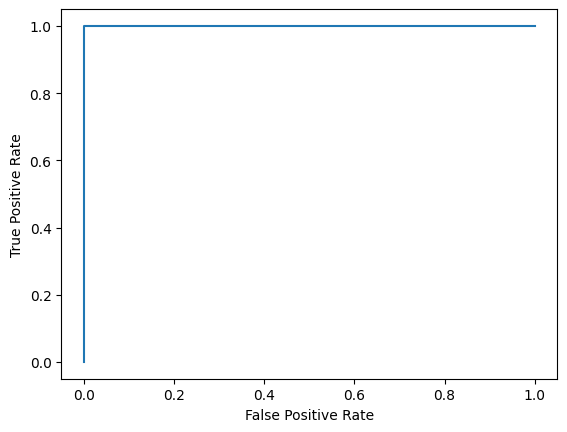

In [269]:
from sklearn import metrics

fpr, tpr, _ = metrics. roc_curve(Q, y_predict)

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 